In [380]:
import pandas as pd
import numpy as np
import re
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import CubicSpline
from matplotlib.ticker import MaxNLocator

In [381]:
df_full = pd.read_csv("processed-data/2023/processed_2023_qc.csv")
df_full["date"] = pd.to_datetime(df_full["date"])

## Checking the quality of data

***QC test categories:***

G - Good


F - Too many minutely flags failed QC


M - Missing too many time-steps


**Data looks good! (except for wind direction)**

In [382]:
df_qc = df_full.loc[:, ["date", "time"] + df_full.columns[df_full.columns.str.startswith("qcscore")].tolist()]
qc_list = [col for col in df_qc.columns if col not in ["date", "time"]]
(df_qc[qc_list].apply(pd.Series.value_counts).fillna(0)
                                             .astype(int)
                                             .sort_values(by="qcscore", ascending=False))

,qcscore,qcscore_maxt,qcscore_mint,qcscore_rh,qcscore_ws,qcscore_wd,qcscore_60rf,qcscore_sol
G,8755,8760,8760,8760,8760,5556,8759,8709
F,5,0,0,0,0,0,0,51
M,0,0,0,0,0,3025,1,0


In [383]:
df = df_full[["date", 
              "time", 
              "Air Temperature in degree C", 
              "Minimum Air Temperature in degree C", 
              "Maximum Air Temperature in degree C",
              "Relative Humidity in %",
              "Wind Speed in km/hr",
              "Wind Direction", 
              "Past 60-Minutes Rainfall in mm", 
              "Solar Radiation in W/m^2"]]

df = df.rename(columns={"Air Temperature in degree C": "temp(c)",
                        "Minimum Air Temperature in degree C": "min_temp(c)",
                        "Maximum Air Temperature in degree C": "max_temp(c)",
                        "Relative Humidity in %": "rel_humid(%)",
                        "Wind Speed in km/hr": "wind_speed(km/hr)",
                        "Wind Direction": "wind_dir",
                        "Past 60-Minutes Rainfall in mm": "rainfall(mm)",
                        "Solar Radiation in W/m^2": "sol_rad(W/m^2)"})

df["hour"] = np.arange(df.shape[0])

# Convert wind speed from km/hr to m/s
df["wind_speed(m/s)"] = df["wind_speed(km/hr)"] * (1000/3600)

# Ensure the time column is numeric and in the correct format
df["time"] = pd.to_datetime(df["time"], format="%H:%M:%S").dt.hour
df["time"] = pd.to_numeric(df["time"])

df.head(5)

,date,time,temp(c),min_temp(c),max_temp(c),rel_humid(%),wind_speed(km/hr),wind_dir,rainfall(mm),sol_rad(W/m^2),hour,wind_speed(m/s)
0,2023-01-01,0,16.0,12.3,19.8,76.5,2.9,9.8,0.0,0.0,0,0.805556
1,2023-01-01,1,16.0,16.0,16.1,76.8,3.1,12.2,0.0,0.0,1,0.861111
2,2023-01-01,2,15.7,15.7,16.1,76.6,3.8,11.1,0.0,0.0,2,1.055556
3,2023-01-01,3,15.2,15.2,16.1,78.5,3.3,8.5,0.0,0.0,3,0.916667
4,2023-01-01,4,15.0,15.0,16.1,79.5,3.7,12.6,0.0,0.0,4,1.027778


# Yearly Analysis

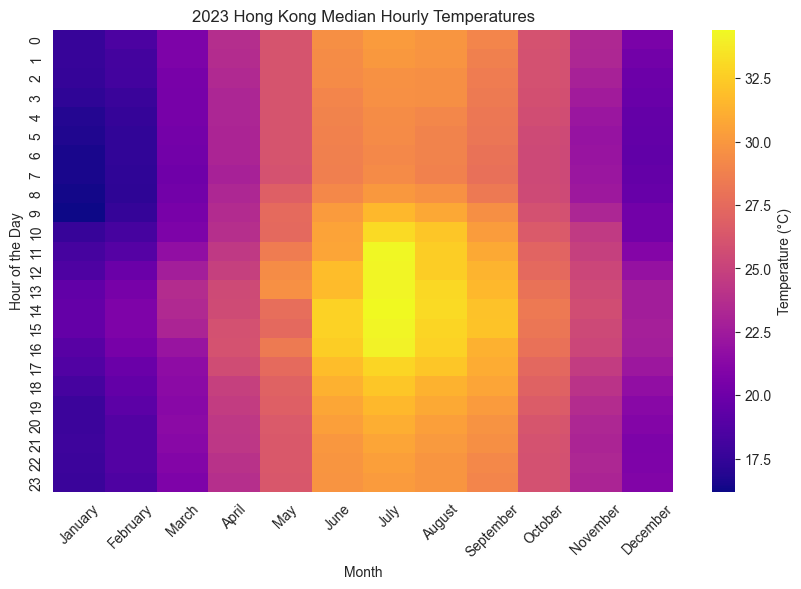

In [384]:
# Plot a heatmap of the median hourly temperature distribution across the whole year
df_temp = df[["date", "time", "temp(c)"]].copy()
df_temp["month"] = df["date"].dt.strftime("%B")
df_temp["month_num"] = df["date"].dt.month
df_temp = df_temp.drop(columns={"date"})
df_avg_hr_temp_year = (df_temp.groupby(["time", "month"])
                              .aggregate("median")
                              .sort_values(by=["month_num", "time"])
                              .reset_index())

month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

df_avg_hr_temp_year["month"] = pd.Categorical(df_avg_hr_temp_year["month"], 
                                              categories=month_order, 
                                              ordered=True)

heatmap_data = df_avg_hr_temp_year.pivot(index="time", 
                                         columns="month", 
                                         values="temp(c)")

# Plot the heatmap
plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_data, 
            annot=False, 
            cmap="plasma", 
            cbar_kws={"label": "Temperature (°C)"})

plt.xticks(rotation=45)
plt.title("2023 Hong Kong Median Hourly Temperatures")
plt.ylabel("Hour of the Day")
plt.xlabel("Month")
plt.savefig("output-graphs/hourly_year_temp.png", dpi=1000)
plt.show()

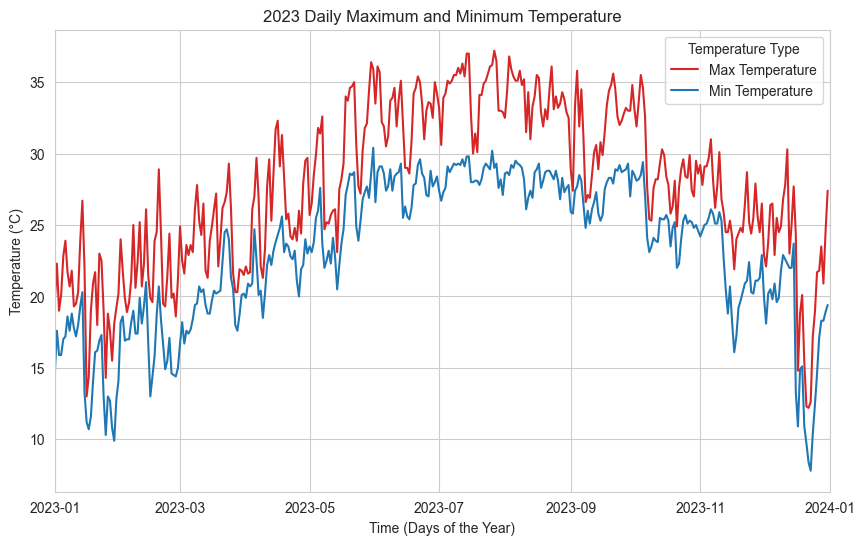

In [385]:
df_maxmin_temp = df[["date", "temp(c)"]].copy()
df_max_grouped = df_maxmin_temp.groupby(["date"]).max().rename(columns={"temp(c)": "max_temp(c)"})
df_min_grouped = df_maxmin_temp.groupby(["date"]).min().rename(columns={"temp(c)": "min_temp(c)"})
df_maxmin = df_max_grouped.merge(df_min_grouped, left_index=True, right_index=True).reset_index()


df_melted = df_maxmin.melt(id_vars=["date"], value_vars=["max_temp(c)", "min_temp(c)"], 
                           var_name="Temperature Type", value_name="Temperature")

# Plot config
custom_palette = {"max_temp(c)": "#D62728", "min_temp(c)": "#1F77B4"}
legend_labels = {"max_temp(c)": "Max Temperature", "min_temp(c)": "Min Temperature"}

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", 
             y="Temperature", 
             hue="Temperature Type", 
             data=df_melted,
             palette=custom_palette) 

sns.set_style("whitegrid")

# Set custom legend
legend = plt.legend(title="Temperature Type")
for text in legend.get_texts():
    text.set_text(legend_labels[text.get_text()])
    
next_month = (df_melted["date"].max() + pd.DateOffset(months=1)).replace(day=1)
    
plt.title("2023 Daily Maximum and Minimum Temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Days of the Year)")
# plt.xticks(rotation=30)
plt.xlim(df_melted["date"].min(), next_month)
plt.savefig("output-graphs/daily_year_maxmin_temp.png", dpi=1000)

plt.show()

##### Bar chart for Cooling Degree Days (CDD) and Heating Degree Days (HDD) Monthly

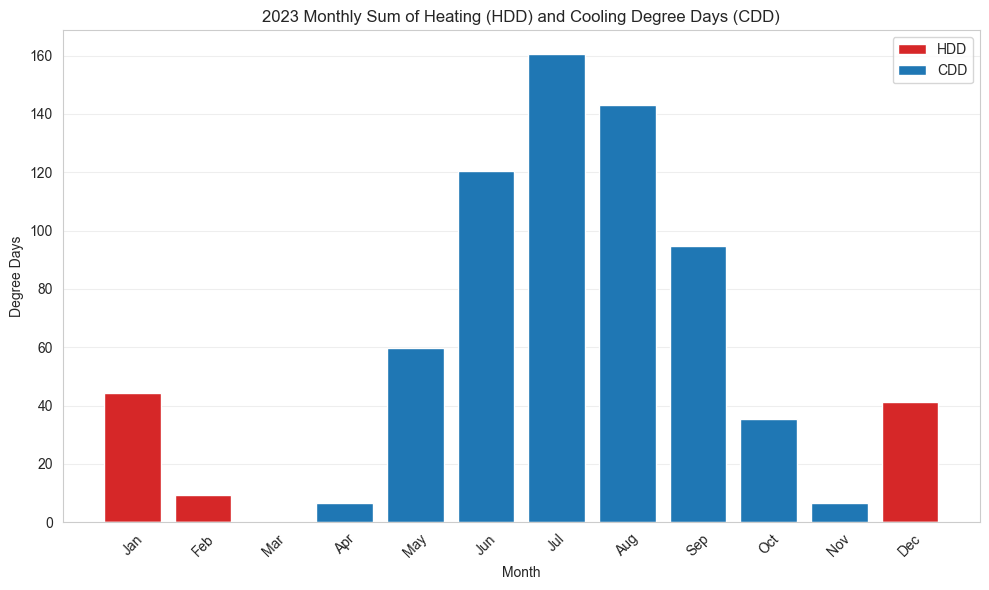

In [386]:
df_cdd = df[["date", "temp(c)"]].groupby("date")["temp(c)"].mean().reset_index()

df_cdd["month"] = df_cdd["date"].dt.strftime("%b")
df_cdd["month_num"] = df_cdd["date"].dt.month
df_avg_hr_temp_year = (df_temp.groupby(["time", "month"])
                              .aggregate("median")
                              .sort_values(by=["month_num", "time"])
                              .reset_index())

# Reference temperatures
hdd_ref = 26
cdd_ref = 18

# Calculate HDD, CDD values, only keeping positive values
df_cdd["cdd"] = (df_cdd["temp(c)"] - hdd_ref).clip(lower=0)  
df_cdd["hdd"] = (cdd_ref - df_cdd["temp(c)"]).clip(lower=0)

df_cdd_month = (df_cdd[["date", "month", "month_num", "hdd", "cdd"]].groupby("month")
                                              .sum([["hdd", "cdd"]])
                                              .sort_values(by=["month_num"])
                                              .reset_index())

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting HDD in red and CDD in blue
ax.bar(df_cdd_month["month"], df_cdd_month["hdd"], color="tab:red", label="HDD")
ax.bar(df_cdd_month["month"], df_cdd_month["cdd"], color="tab:blue", label="CDD")

# Adding labels and title
ax.set_xlabel("Month")
ax.set_ylabel("Degree Days")
ax.set_title("2023 Monthly Sum of Heating (HDD) and Cooling Degree Days (CDD)")
ax.legend()

ax.xaxis.grid(False)
ax.yaxis.grid(True, color="#EEEEEE")

# Show/save plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("output-graphs/monthly_hdd_cdd.png", dpi=1000)
plt.show()

In [387]:
df_cdd_month

,month,month_num,hdd,cdd
0,Jan,31,44.191667,0.000000
1,Feb,56,9.325000,0.000000
2,Mar,93,0.000000,0.125000
3,Apr,120,0.000000,6.733333
4,May,155,0.000000,59.604167
5,Jun,180,0.000000,120.337500
6,Jul,217,0.000000,160.620833
7,Aug,248,0.000000,143.225000
8,Sep,270,0.000000,94.695833
9,Oct,310,0.000000,35.512500


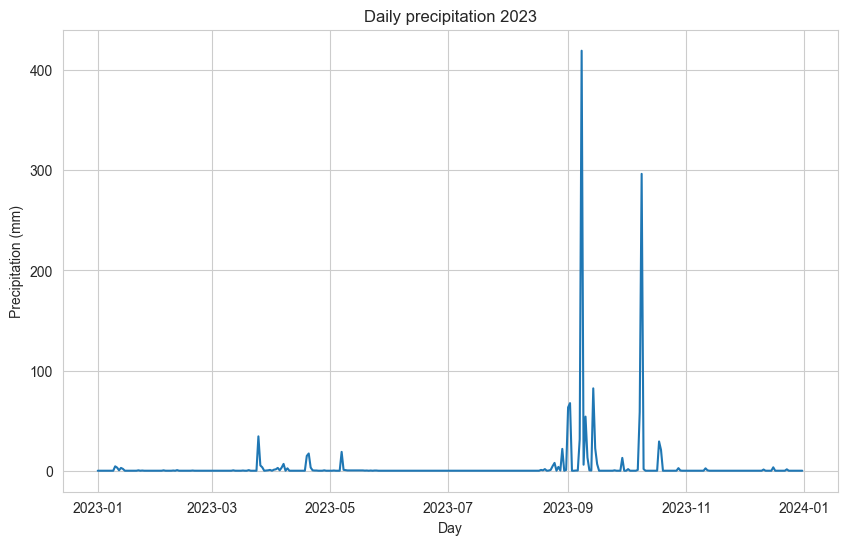

In [388]:
df_precip = df[["date", "rainfall(mm)"]]
df_precip_daily = df[["date", "rainfall(mm)"]].groupby("date")["rainfall(mm)"].sum().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))

sns.lineplot(x="date", y="rainfall(mm)", data=df_precip_daily)
plt.title("Daily precipitation 2023")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Day")
# plt.xticks(list(df_jan_wk["hour"][::24]) + [df_jan_wk["hour"].iloc[-1]])
plt.show()

##### No precipitation recorded in June and July, even though the average in Hong Kong was high. Most like an error in data collection.

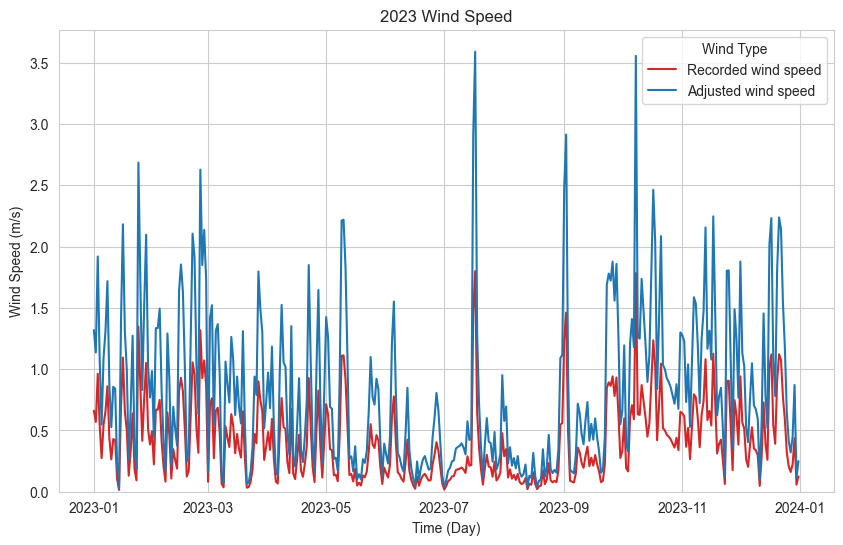

In [389]:
# Properly converting wind speed from recorded height (18.5m) to an apartment on the 35th floor (160m)

# Use power law to interpolate wind speed properly at 35 storeys high
z = 160 # apartment elevation in metres
z_ref = 18.5 # elevation of point of data collection in metres
alpha = 0.32 # power law exponent

df["wind_speed_adj(km/hr)"] = df["wind_speed(km/hr)"] * (z / z_ref) ** alpha
df["wind_speed_adj(m/s)"] = df["wind_speed(m/s)"] * (z / z_ref) ** alpha

df_wind_daily = df.groupby("date")[["wind_speed(m/s)", "wind_speed_adj(m/s)"]].mean().reset_index()

df_melted_wind = df_wind_daily.melt(id_vars=["date"], value_vars=["wind_speed(m/s)", "wind_speed_adj(m/s)"], 
                           var_name="Wind Type", value_name="Wind")

# Plot config
custom_palette = {"wind_speed(m/s)": "#D62728", "wind_speed_adj(m/s)": "#1F77B4"}
legend_labels = {"wind_speed(m/s)": "Recorded wind speed", "wind_speed_adj(m/s)": "Adjusted wind speed"}

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", 
             y="Wind", 
             hue="Wind Type", 
             data=df_melted_wind,
             palette=custom_palette) 

sns.set_style("whitegrid")

# Set custom legend
legend = plt.legend(title="Wind Type")
for text in legend.get_texts():
    text.set_text(legend_labels[text.get_text()])
    
plt.title("2023 Wind Speed")
plt.ylabel("Wind Speed (m/s)")
plt.xlabel("Time (Day)")
# plt.xticks(rotation=30)
# plt.savefig("output-graphs/daily_summer_windspeed.png", dpi=1000)
plt.ylim(0)

plt.show()

C:\Users\marco\AppData\Local\Temp\ipykernel_9984\2247436588.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean = df.resample('M', on='date')[["wind_speed(m/s)", "wind_speed_adj(m/s)"]].mean()  # Mean for each month
C:\Users\marco\AppData\Local\Temp\ipykernel_9984\2247436588.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_25 = df.resample('M', on='date')[["wind_speed(m/s)", "wind_speed_adj(m/s)"]].quantile(0.25)  # 25th percentile
C:\Users\marco\AppData\Local\Temp\ipykernel_9984\2247436588.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_75 = df.resample('M', on='date')[["wind_speed(m/s)", "wind_speed_adj(m/s)"]].quantile(0.75)  # 75th percentile


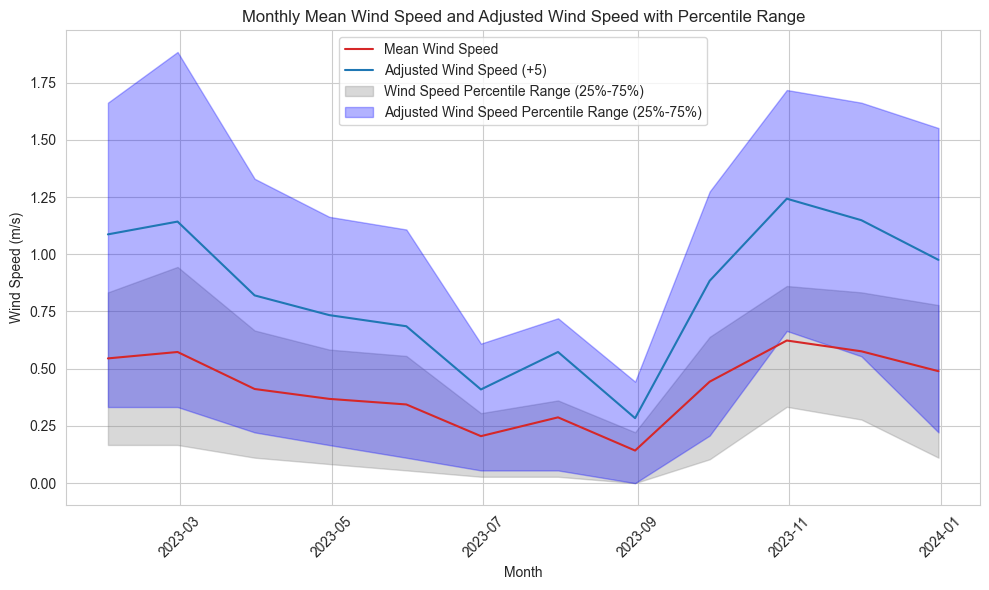

In [390]:
# Resample to monthly data, calculating the mean and 25% and 75% percentiles for wind speed and adjusted wind speed
monthly_mean = df.resample('M', on='date')[["wind_speed(m/s)", "wind_speed_adj(m/s)"]].mean()  # Mean for each month
monthly_25 = df.resample('M', on='date')[["wind_speed(m/s)", "wind_speed_adj(m/s)"]].quantile(0.25)  # 25th percentile
monthly_75 = df.resample('M', on='date')[["wind_speed(m/s)", "wind_speed_adj(m/s)"]].quantile(0.75)  # 75th percentile

# Plotting the monthly means
plt.figure(figsize=(10, 6))

# Plot the wind speed and adjusted wind speed lines
plt.plot(monthly_mean.index, monthly_mean["wind_speed(m/s)"], label='Mean Wind Speed', color='tab:red')
plt.plot(monthly_mean.index, monthly_mean["wind_speed_adj(m/s)"], label='Adjusted Wind Speed (+5)', color='tab:blue')

# Fill the shaded areas for the 25% and 75% percentiles
plt.fill_between(monthly_mean.index, monthly_25["wind_speed(m/s)"], monthly_75["wind_speed(m/s)"], color='gray', alpha=0.3, label='Wind Speed Percentile Range (25%-75%)')
plt.fill_between(monthly_mean.index, monthly_25["wind_speed_adj(m/s)"], monthly_75["wind_speed_adj(m/s)"], color='blue', alpha=0.3, label='Adjusted Wind Speed Percentile Range (25%-75%)')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.title('Monthly Mean Wind Speed and Adjusted Wind Speed with Percentile Range')

# Display the legend
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig("output-graphs/monthly_mean_wind.png", dpi=1000)
plt.show()

In [391]:
print(f"Mean wind speed (year): {df['wind_speed_adj(m/s)'].mean()} [m/s]")

Mean wind speed (year): 0.829965215983511 [m/s]


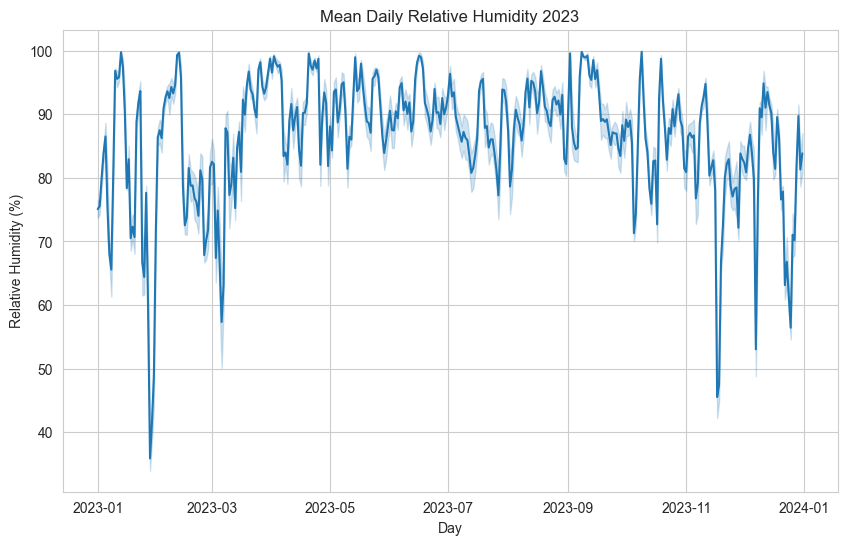

In [392]:
df_humid = df[["date", "rel_humid(%)"]].copy()
# df_humid = df_humid[df_humid["date"] > "2023-10-01"]
# df_humid_daily = df_humid.groupby("hour")["rel_humid(%)"].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))


sns.lineplot(x="date", y="rel_humid(%)", data=df_humid)
plt.title("Mean Daily Relative Humidity 2023")
plt.ylabel("Relative Humidity (%)")
plt.xlabel("Day")
# plt.xticks(list(df_jan_wk["hour"][::24]) + [df_jan_wk["hour"].iloc[-1]])
plt.show()

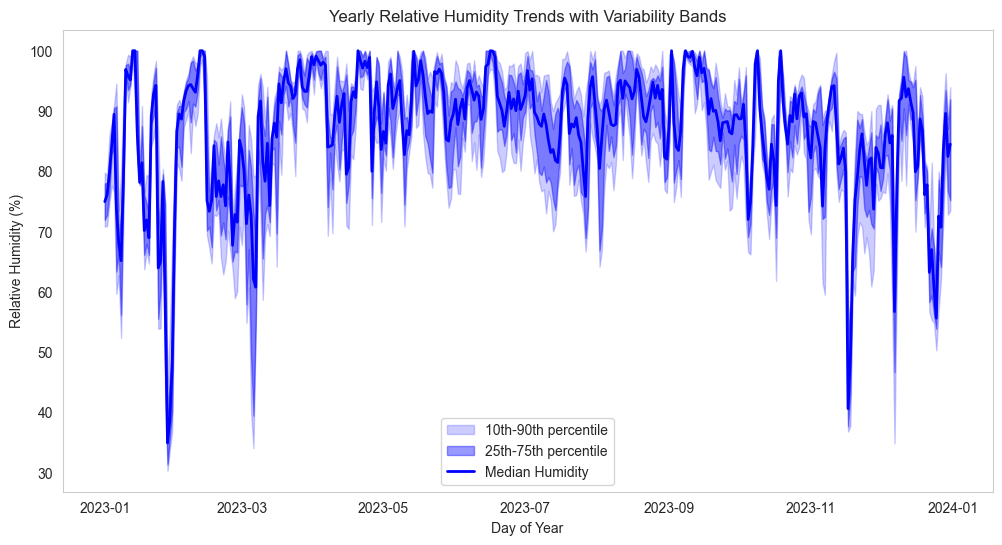

In [393]:
percentiles = df_humid.groupby("date")["rel_humid(%)"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

# Extract values
days = percentiles.index



p10, p25, median, p75, p90 = percentiles["10%"], percentiles["25%"], percentiles["50%"], percentiles["75%"], percentiles["90%"]



plt.figure(figsize=(12, 6))

# Plot percentile bands
plt.fill_between(days, p10, p90, color="blue", alpha=0.2, label="10th-90th percentile")
plt.fill_between(days, p25, p75, color="blue", alpha=0.4, label="25th-75th percentile")

# Plot median
plt.plot(days, median, color="blue", linewidth=2, label="Median Humidity")

# Formatting
plt.xlabel("Day of Year")
plt.ylabel("Relative Humidity (%)")
plt.title("Yearly Relative Humidity Trends with Variability Bands")
plt.legend()
plt.grid()
plt.show()

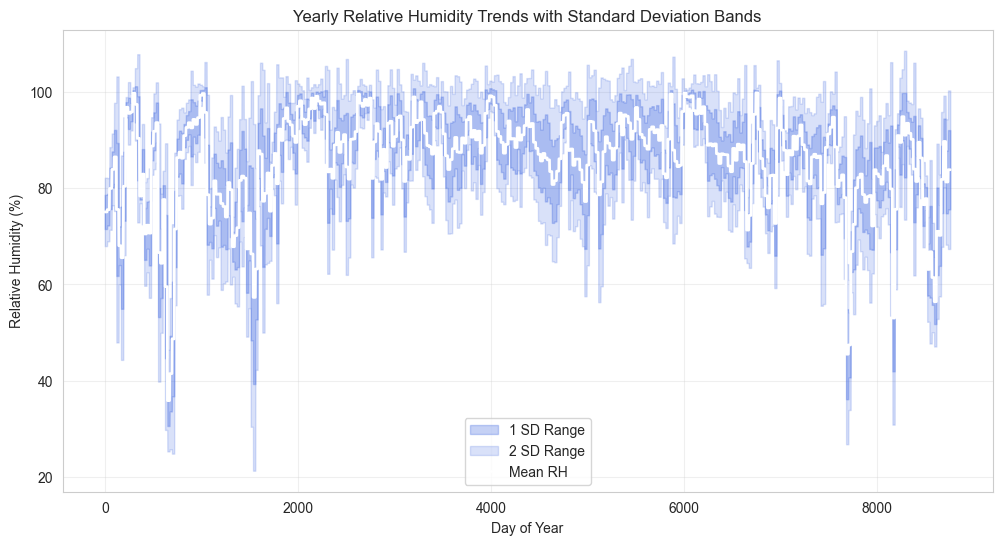

In [394]:
df_humid["mean_rh"] = df_humid["rel_humid(%)"].groupby(df_humid["date"]).transform("mean")  # Mean daily RH
df_humid["std_rh"] = df_humid["rel_humid(%)"].groupby(df_humid["date"]).transform("std")  # SD of daily RH

plt.figure(figsize=(12,6))

# Shaded region = Mean ± 1 SD
plt.fill_between(df.index, df_humid["mean_rh"] - df_humid["std_rh"], df_humid["mean_rh"] + df_humid["std_rh"],
                 color="royalblue", alpha=0.3, label="1 SD Range")

# Shaded region = Mean ± 2 SD
plt.fill_between(df.index, df_humid["mean_rh"] - 2*df_humid["std_rh"], df_humid["mean_rh"] + 2*df_humid["std_rh"],
                 color="royalblue", alpha=0.2, label="2 SD Range")

# Solid Line for Mean RH
plt.plot(df_humid.index, df_humid["mean_rh"], color="white", linewidth=2, label="Mean RH")

plt.title("Yearly Relative Humidity Trends with Standard Deviation Bands")
plt.xlabel("Day of Year")
plt.ylabel("Relative Humidity (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

# Seasonal Analysis

In [395]:
df_summer = df[(df["date"] >= "2023-06-01") & (df["date"] < "2023-09-01")].copy()
df_winter = df[ (df["date"] < "2023-03-01") |
               (df["date"] >= "2023-12-01")].copy()

### Interpolating wind speed 35 storeys high (35th floor)

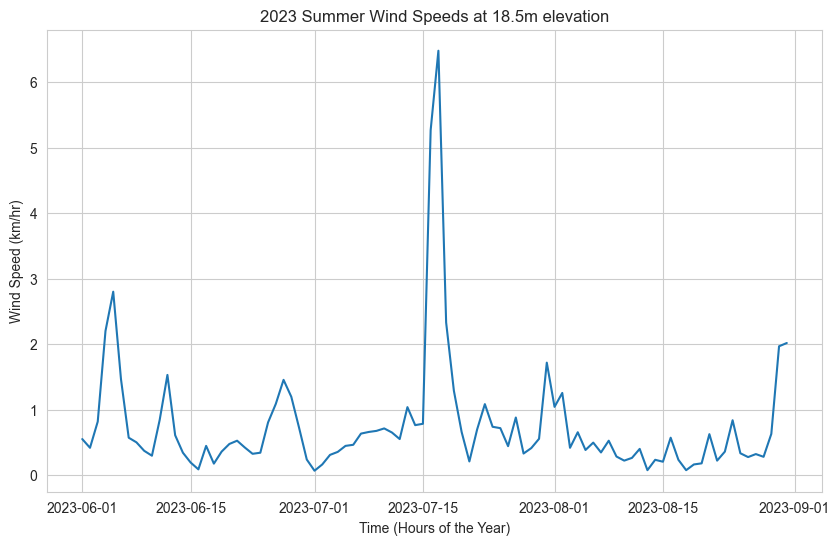

In [396]:
plt.figure(figsize=(10, 6))

df_summer_day = df_summer.groupby("date")[["wind_speed(km/hr)", 
                                           "temp(c)",
                                           "rel_humid(%)"]].mean().reset_index()

df_winter_day = df_winter.groupby("date")["wind_speed(km/hr)"].mean().reset_index()

sns.lineplot(x="date", y="wind_speed(km/hr)", data=df_summer_day)
plt.title("2023 Summer Wind Speeds at 18.5m elevation")
plt.ylabel("Wind Speed (km/hr)")
plt.xlabel("Time (Hours of the Year)")
# plt.xticks(list(df_summer["hour"][::24]) + [df_summer["hour"].iloc[-1]])
plt.show()

In [397]:
# Summer mean wind speed and temperature
print(df_summer_day["wind_speed(km/hr)"].mean())
print(df_summer_day["temp(c)"].mean())

0.761911231884058
30.610688405797102


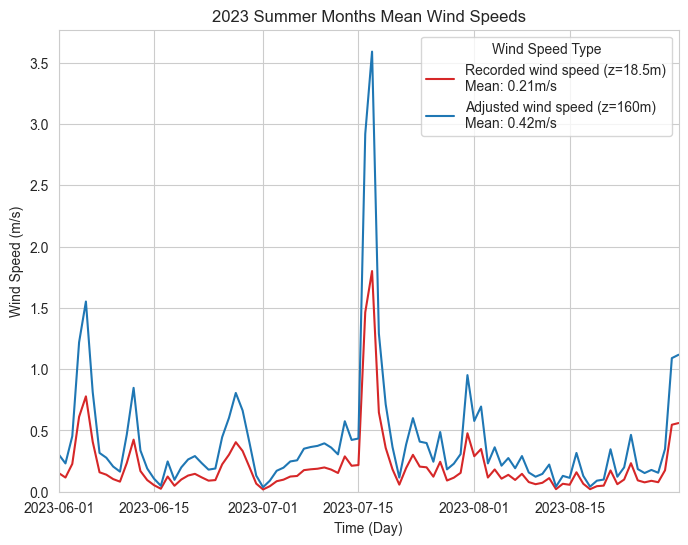

In [398]:
# Use power law to interpolate wind speed properly at 35 storeys high
z = 160 # apartment elevation in metres
z_ref = 18.5 # elevation of point of data collection in metres
alpha = 0.32 # power law exponent

df_summer["wind_speed_adj(km/hr)"] = df_summer["wind_speed(km/hr)"] * (z / z_ref) ** alpha
df_summer["wind_speed_adj(m/s)"] = df_summer["wind_speed(m/s)"] * (z / z_ref) ** alpha

df_summer_day = df_summer.groupby("date")[["wind_speed(m/s)", 
                                          "wind_speed_adj(m/s)"]].mean().reset_index()

df_melted_wind = df_summer_day.melt(id_vars=["date"], value_vars=["wind_speed(m/s)", "wind_speed_adj(m/s)"], 
                           var_name="Wind Type", value_name="Wind")

# Plot config
custom_palette = {"wind_speed(m/s)": "#D62728", "wind_speed_adj(m/s)": "#1F77B4"}
legend_labels = {"wind_speed(m/s)": "Recorded wind speed (z=18.5m)\nMean: 0.21m/s", 
                 "wind_speed_adj(m/s)": "Adjusted wind speed (z=160m)\nMean: 0.42m/s"}


# Create the plot
plt.figure(figsize=(8, 6))
sns.lineplot(x="date", 
             y="Wind", 
             hue="Wind Type", 
             data=df_melted_wind,
             palette=custom_palette) 

sns.set_style("whitegrid")

# Set custom legend
legend = plt.legend(title="Wind Speed Type")
for text in legend.get_texts():
    text.set_text(legend_labels[text.get_text()])
    
plt.title("2023 Summer Months Mean Wind Speeds")
plt.ylabel("Wind Speed (m/s)")
plt.xlabel("Time (Day)")

# Set x-axis limits to match the data range (removes left/right gaps)
plt.xlim(df_melted_wind["date"].min(), df_melted_wind["date"].max())
plt.ylim(0,)
# plt.xticks(rotation=30)
plt.savefig("output-graphs/daily_summer_windspeed.png", dpi=1000)

plt.show()

In [399]:
print(df_summer["wind_speed(m/s)"].mean())
print(df_summer["wind_speed_adj(m/s)"].mean())

0.21164200885668277
0.42210968463319565


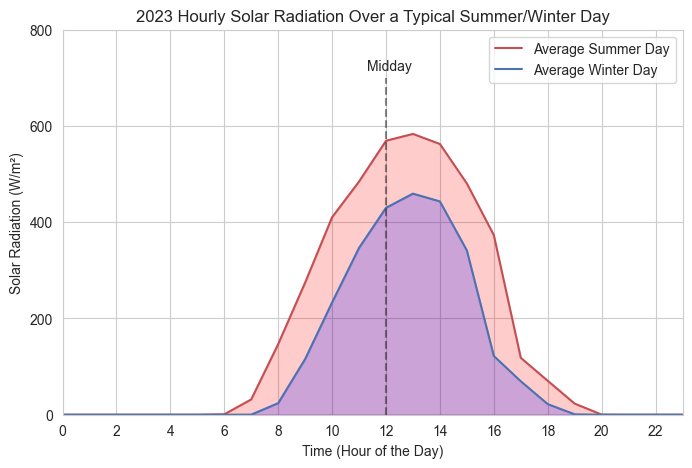

In [400]:
df_summer_sol = (df_summer[["time", "sol_rad(W/m^2)"]].groupby(by="time")
                                                      .mean()
                                                      .rename(columns={"sol_rad(W/m^2)": "summer_sol"})
                                                      .reset_index())
df_winter_sol = (df_winter[["time", "sol_rad(W/m^2)"]].groupby(by="time")
                                                      .mean()
                                                      .rename(columns={"sol_rad(W/m^2)": "winter_sol"})
                                                      .reset_index())

df_sol = df_summer_sol.merge(df_winter_sol, on="time", how="outer", indicator=True).reset_index()  

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_sol["time"], df_sol["summer_sol"], "r", label="Average Summer Day")
plt.plot(df_sol["time"], df_sol["winter_sol"], "b", label="Average Winter Day")
plt.fill_between(df_sol["time"], df_sol["summer_sol"], color='red', alpha=0.2)
plt.fill_between(df_sol["time"], df_sol["winter_sol"], color='blue', alpha=0.2)

# Annotate Midday
plt.plot([12, 12], [0, 700], color='k', linestyle="--", alpha=0.5)
plt.text(11.3, 710, "Midday", rotation=0, verticalalignment='bottom', fontsize=10)

# Labels and legend
plt.xlabel("Time (Hour of the Day)")
plt.ylabel("Solar Radiation (W/m²)")
plt.title("2023 Hourly Solar Radiation Over a Typical Summer/Winter Day")
plt.xticks(range(0, 24, 2))
plt.yticks(range(0, 1000, 200))
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)


plt.xlim(df_sol["time"].min(), df_sol["time"].max())

plt.savefig("output-graphs/solrad_summer_winter.png", dpi=1000)

# Show plot
plt.show()

In [401]:
print(f"Mean Relative Humidity during winter period: {df_winter['rel_humid(%)'].mean()}")
print(f"Mean Temperature during winter period: {df_winter['temp(c)'].mean()}")
print(f"Mean Temperature during winter period: {df_winter['wind_speed_adj(m/s)'].mean()}")

Mean Relative Humidity during winter period: 80.22189814814814
Mean Temperature during winter period: 18.58898148148148
Mean Temperature during winter period: 1.0657336282799603


# Weekly Analysis

Extracting data from the wk of the 2nd Monday of January and July to represent Winter and Summer weather in Hong Kong.

In [402]:
df_jan_wk = df[(df["date"] >= "2023-01-09") & (df["date"] < "2023-01-16")].copy()
df_july_wk = df[(df["date"] >= "2023-07-10") & (df["date"] < "2023-07-17")].copy()

### January week graphs

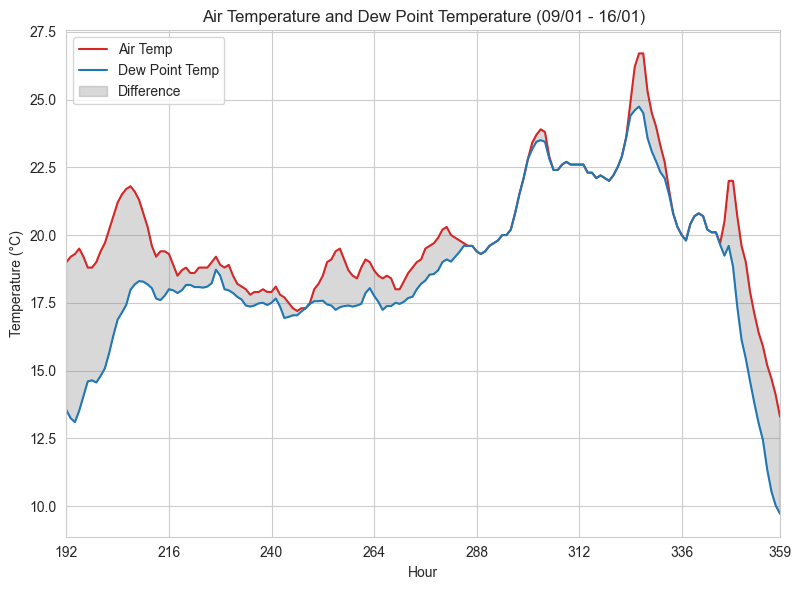

In [403]:
df_jan_wk["dewp_temp(c)"] = df_jan_wk["temp(c)"] - ((100 - df_jan_wk["rel_humid(%)"])/5)


# Plot air temperature and dew point
plt.figure(figsize=(8, 6))

# Plot air temperature
plt.plot(df_jan_wk["hour"], df_jan_wk["temp(c)"], label="Air Temp", color="tab:red")

# Plot dew point temperature
plt.plot(df_jan_wk["hour"], df_jan_wk["dewp_temp(c)"], label="Dew Point Temp", color="tab:blue")

# Shade the area between the air temperature and dew point
plt.fill_between(df_jan_wk["hour"], df_jan_wk["temp(c)"], df_jan_wk["dewp_temp(c)"], where=(df_jan_wk["temp(c)"] > df_jan_wk["dewp_temp(c)"]),
                 color="gray", alpha=0.3, label="Difference")

# Add labels and title
plt.xlabel("Hour")  
plt.ylabel("Temperature (°C)")
plt.title("Air Temperature and Dew Point Temperature (09/01 - 16/01)")

# Show the legend
plt.legend()
plt.xticks(list(df_jan_wk["hour"][::24]) + [df_jan_wk["hour"].iloc[-1]])
plt.tight_layout() 

# Display the plot
plt.grid(True)
plt.xlim(df_jan_wk["hour"].iloc[0], df_jan_wk["hour"].iloc[-1])

plt.savefig("output-graphs/jan_wk_dewptemp.png", dpi=1000)
plt.show()

##### The high relative humidity observed during this period indicates an increase in energy demand, as the increased moisture in the air makes it feel colder indoors.

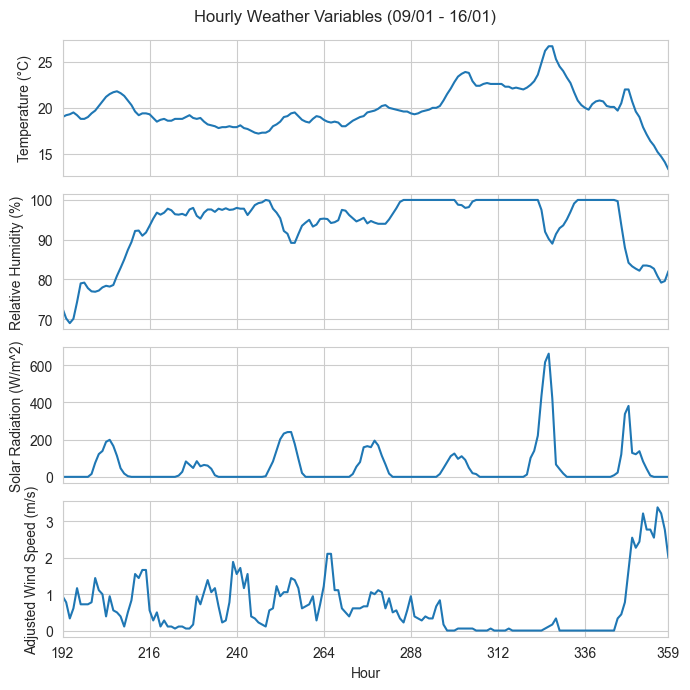

In [404]:
cols_plot = {"temp(c)": "Temperature (°C)",  
             "rel_humid(%)": "Relative Humidity (%)",
             "sol_rad(W/m^2)": "Solar Radiation (W/m^2)",
             "wind_speed_adj(m/s)": "Adjusted Wind Speed (m/s)"}

fig, axes = plt.subplots(len(cols_plot), 1, figsize=(7, 7), sharex=True)

# Loop through each column and plot on a separate subplot
for i, (key, value) in enumerate(cols_plot.items()):
    cleaned_label = re.sub(r"\s*\(.*?\)", "", value)
    sns.lineplot(x="hour", y=key, data=df_jan_wk, ax=axes[i])
    # axes[i].set_title(f"09/01 - 16/01 Hourly {cleaned_label}")
    axes[i].set_ylabel(value)
    axes[i].set_xlim(df_jan_wk["hour"].min(), df_jan_wk["hour"].max())


# Set common x-axis label
axes[-1].set_xlabel("Hour")

plt.xticks(list(df_jan_wk["hour"][::24]) + [df_jan_wk["hour"].iloc[-1]])
plt.suptitle("Hourly Weather Variables (09/01 - 16/01)")

plt.tight_layout()

plt.savefig("output-graphs/jan_week_var.png", dpi=1000)
plt.show()                                 

### July week Graphs

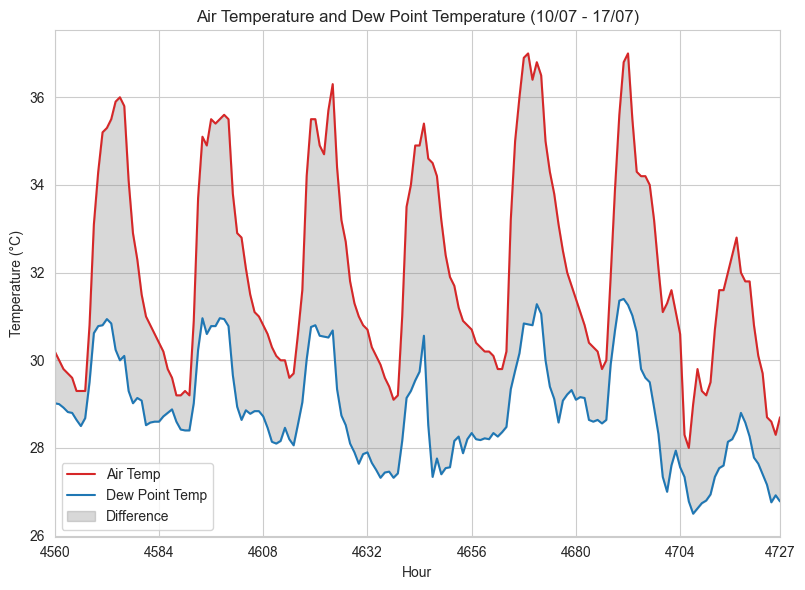

In [405]:
df_july_wk["dewp_temp(c)"] = df_july_wk["temp(c)"] - ((100 - df_july_wk["rel_humid(%)"])/5)


# Plot air temperature and dew point
plt.figure(figsize=(8, 6))

# Plot air temperature
plt.plot(df_july_wk["hour"], df_july_wk["temp(c)"], label="Air Temp", color="tab:red")

# Plot dew point temperature
plt.plot(df_july_wk["hour"], df_july_wk["dewp_temp(c)"], label="Dew Point Temp", color="tab:blue")

# Shade the area between the air temperature and dew point
plt.fill_between(df_july_wk["hour"], df_july_wk["temp(c)"], df_july_wk["dewp_temp(c)"], where=(df_july_wk["temp(c)"] > df_july_wk["dewp_temp(c)"]),
                 color="gray", alpha=0.3, label="Difference")

# Add labels and title
plt.xlabel("Hour")  
plt.ylabel("Temperature (°C)")
plt.title("Air Temperature and Dew Point Temperature (10/07 - 17/07)")

# Show the legend
plt.legend()

plt.xticks(list(df_july_wk["hour"][::24]) + [df_july_wk["hour"].iloc[-1]])
plt.tight_layout() 

# Display the plot
plt.grid(True)
plt.xlim(df_july_wk["hour"].iloc[0], df_july_wk["hour"].iloc[-1])
plt.savefig("output-graphs/jul_week_dewptemp.png", dpi=1000)
plt.show()

##### High relative humidity at night may require dehumidification, as it causes discomfort, in turn, increasing energy demand.

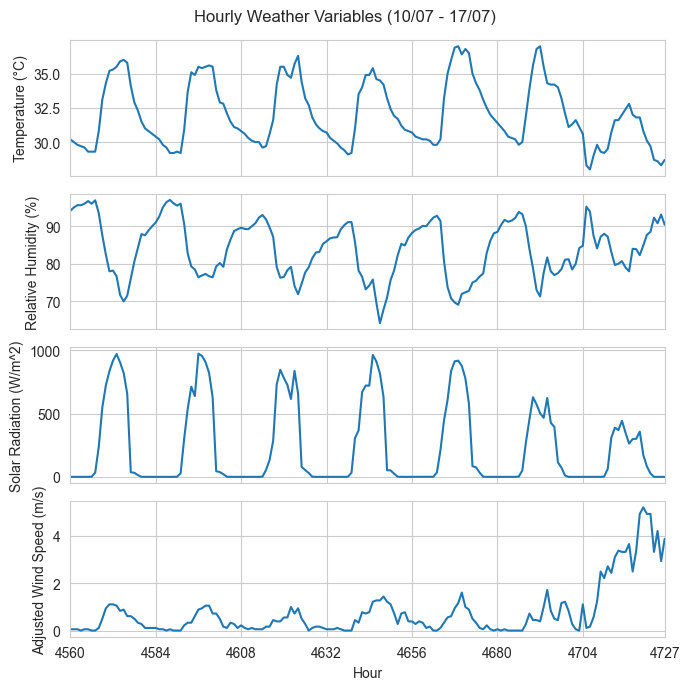

In [406]:
cols_plot = {"temp(c)": "Temperature (°C)",  
             "rel_humid(%)": "Relative Humidity (%)",
             "sol_rad(W/m^2)": "Solar Radiation (W/m^2)",
             "wind_speed_adj(m/s)": "Adjusted Wind Speed (m/s)"}

fig, axes = plt.subplots(len(cols_plot), 1, figsize=(7, 7), sharex=True)

# Loop through each column and plot on a separate subplot
for i, (key, value) in enumerate(cols_plot.items()):
    cleaned_label = re.sub(r"\s*\(.*?\)", "", value)
    sns.lineplot(x="hour", y=key, data=df_july_wk, ax=axes[i])
    # axes[i].set_title(f"10/07 - 17/07 Hourly {cleaned_label}")
    axes[i].set_ylabel(value)
    axes[i].set_xlim(df_july_wk["hour"].min(), df_july_wk["hour"].max())

# Set common x-axis label
axes[-1].set_xlabel("Hour")

plt.suptitle("Hourly Weather Variables (10/07 - 17/07)")
plt.xticks(list(df_july_wk["hour"][::24]) + [df_july_wk["hour"].iloc[-1]])

plt.tight_layout() 

plt.savefig("output-graphs/jul_week_var.png", dpi=1000)
plt.show()

# Solar Radiation and Temperature Correlation Investigation

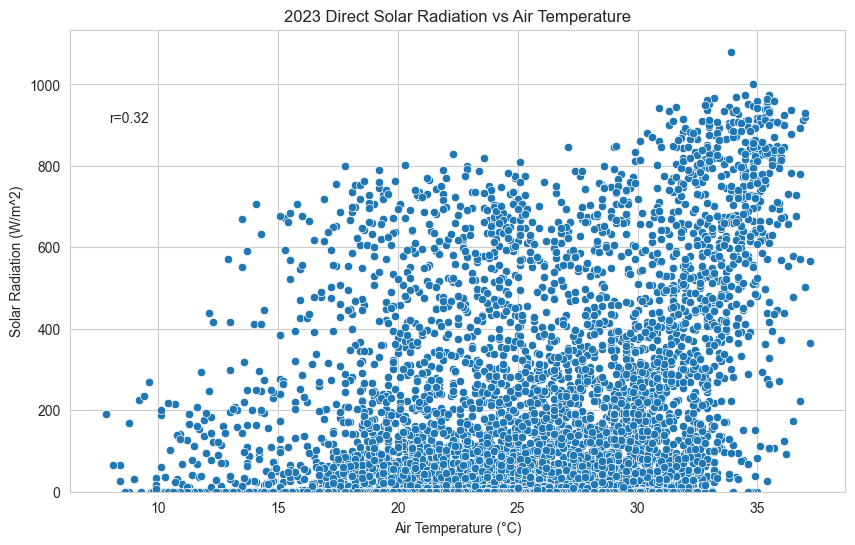

In [407]:
df_soltemp = df[["date", "time", "temp(c)", "sol_rad(W/m^2)"]]

plt.figure(figsize=(10, 6))

sns.scatterplot(x="temp(c)", y="sol_rad(W/m^2)", data=df_soltemp)

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_soltemp["temp(c)"], y=df_soltemp["sol_rad(W/m^2)"])
# annotate the pearson correlation coefficient text to 2 decimal places
ax = plt.gca() 
plt.text(.05, .8, 'r={:.2f}'.format(r), transform=ax.transAxes)

plt.title("2023 Direct Solar Radiation vs Air Temperature")
plt.ylabel("Solar Radiation (W/m^2)")
plt.xlabel("Air Temperature (°C)")
plt.ylim(bottom=0)
plt.show()

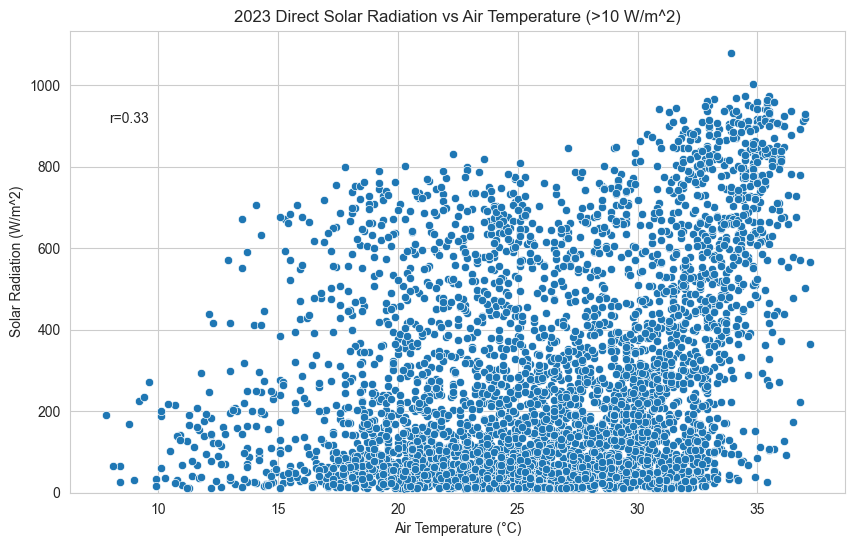

In [408]:
# Filtering out results where there is no significant solar radiation
df_soltemp = df[df["sol_rad(W/m^2)"] > 10]

plt.figure(figsize=(10, 6))

sns.scatterplot(x="temp(c)", y="sol_rad(W/m^2)", data=df_soltemp)

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_soltemp["temp(c)"], y=df_soltemp["sol_rad(W/m^2)"])
# annotate the pearson correlation coefficient text to 2 decimal places
ax = plt.gca() 
plt.text(.05, .8, 'r={:.2f}'.format(r), transform=ax.transAxes)

plt.title("2023 Direct Solar Radiation vs Air Temperature (>10 W/m^2)")
plt.ylabel("Solar Radiation (W/m^2)")
plt.xlabel("Air Temperature (°C)")
plt.ylim(bottom=0)
plt.show()

In [409]:
df_soltemp_winter = df_soltemp[(df_soltemp["date"] >= "2023-12-01") | (df_soltemp["date"] < "2023-03-01")].copy()
df_soltemp_summer = df_soltemp[(df_soltemp["date"] >= "2023-06-01") & (df_soltemp["date"] < "2023-09-01")].copy()

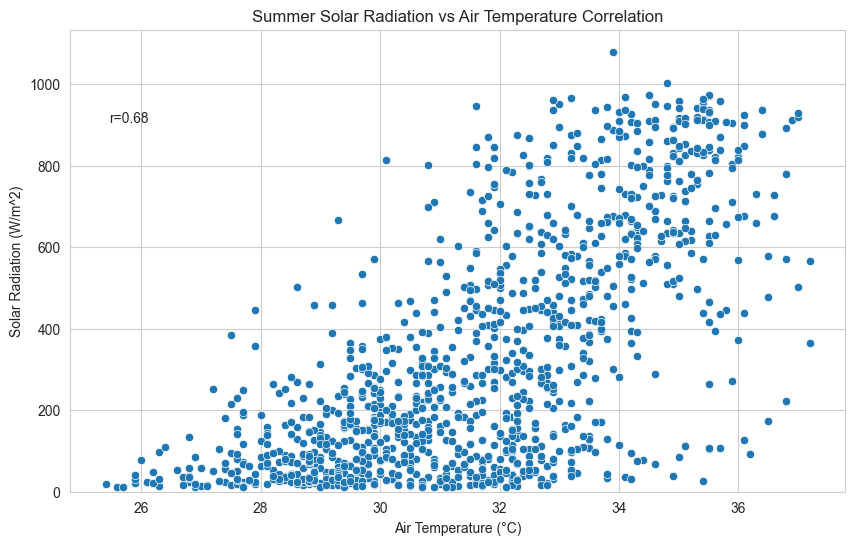

In [419]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x="temp(c)", y="sol_rad(W/m^2)", data=df_soltemp_summer)

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_soltemp_summer["temp(c)"], y=df_soltemp_summer["sol_rad(W/m^2)"])
# annotate the pearson correlation coefficient text to 2 decimal places
ax = plt.gca() 
plt.text(.05, .8, 'r={:.2f}'.format(r), transform=ax.transAxes)

plt.title("Summer Solar Radiation vs Air Temperature Correlation")
plt.ylabel("Solar Radiation (W/m^2)")
plt.xlabel("Air Temperature (°C)")
plt.ylim(bottom=0)
#plt.tight_layout()
plt.savefig("output-graphs/summer_solrad_temp_corr.png", dpi=1000)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x="temp(c)", y="sol_rad(W/m^2)", data=df_soltemp_winter)

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_soltemp_winter["temp(c)"], y=df_soltemp_winter["sol_rad(W/m^2)"])
# annotate the pearson correlation coefficient text to 2 decimal places
ax = plt.gca() 
plt.text(.05, .8, 'r={:.2f}'.format(r), transform=ax.transAxes)

plt.title("Winter Solar Radiation vs Air Temperature Correlation")
plt.ylabel("Solar Radiation (W/m^2)")
plt.xlabel("Air Temperature (°C)")
plt.ylim(bottom=0)
plt.savefig("output-graphs/winter_solrad_temp_corr.png", dpi=1000)
plt.show()

# Air temperature interpolation for modelling

##### Winter - 10/01/2023, Summer - 11/07/2023

In [412]:
df_day_temp = df[["date", "time", "temp(c)"]]

df_wnt_day = df_day_temp[df_day_temp["date"] == "2023-01-10"]
df_sum_day = df_day_temp[df_day_temp["date"] == "2023-07-11"]

df_wnt_day = df_wnt_day.drop(columns=["date"])
df_sum_day = df_sum_day.drop(columns=["date"])

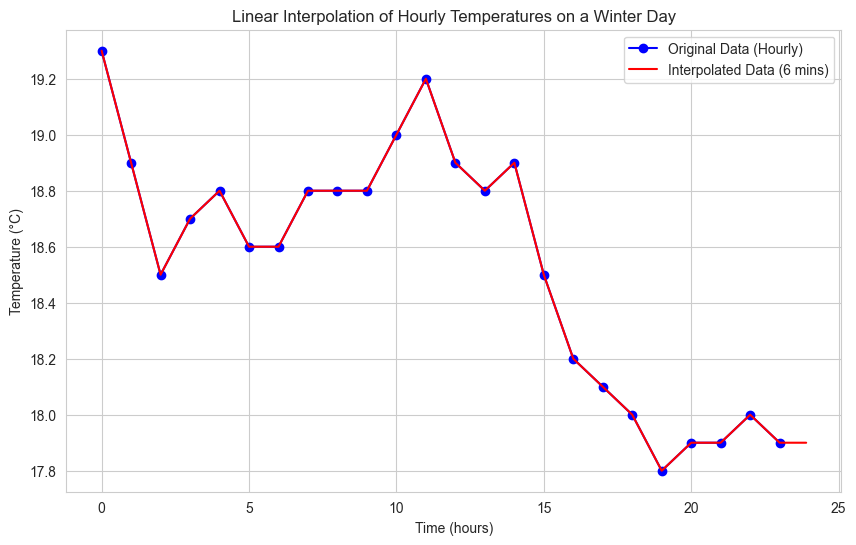

In [413]:
# Create linear interpolator

new_time = np.arange(df_wnt_day["time"].min(), df_wnt_day["time"].max() + 1, 1/10)  # 1/10 for 10 time steps per hour

# Perform linear interpolation
df_interpolated = pd.DataFrame({"time": new_time})
df_interpolated["temp(c)"] = np.interp(new_time, df_wnt_day["time"], df_wnt_day["temp(c)"])

# Plot the original data and the interpolated data
plt.figure(figsize=(10, 6))
plt.plot(df_wnt_day["time"], df_wnt_day["temp(c)"], "o-", label="Original Data (Hourly)", color="blue")
plt.plot(df_interpolated["time"], df_interpolated["temp(c)"], "-", label="Interpolated Data (6 mins)", color="red")

# Add labels and legend
plt.title("Linear Interpolation of Hourly Temperatures on a Winter Day")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

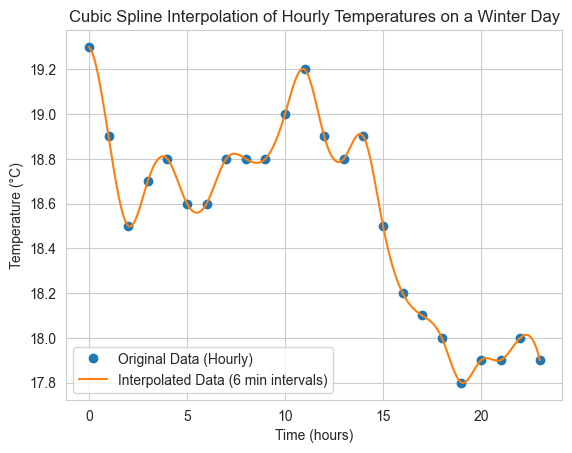

In [414]:
# Create cubic spline interpolator

cs = CubicSpline(df_wnt_day["time"], df_wnt_day["temp(c)"])

new_time = np.linspace(df_wnt_day["time"].min(), df_wnt_day["time"].max(), 24*10)  # 24 hours with 10 time steps each: 24 * 10

# Interpolate the temperature at these new time points
interpolated_temps = cs(new_time)
interpolated_temps = np.round(interpolated_temps, 10)

# Create a DataFrame for better visualization
df_interpolated_wnt = pd.DataFrame({
    "time": new_time,
    "temp_w(c)": interpolated_temps
})

# Plot the original data and the interpolated data
plt.plot(df_wnt_day["time"], df_wnt_day["temp(c)"], "o", label="Original Data (Hourly)")
plt.plot(df_interpolated_wnt["time"], df_interpolated_wnt["temp_w(c)"], "-", label="Interpolated Data (6 min intervals)")
plt.title("Cubic Spline Interpolation of Hourly Temperatures on a Winter Day")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

df_interpolated_wnt.to_csv("processed-data/20230110_interpolated.csv", index=False)

In [415]:
df_interpolated_wnt

,time,temp_w(c)
0,0.000000,19.300000
1,0.096234,19.288246
2,0.192469,19.268381
3,0.288703,19.241271
4,0.384937,19.207777
...,...,...
235,22.615063,17.993707
236,22.711297,17.978390
237,22.807531,17.957960
238,22.903766,17.931977


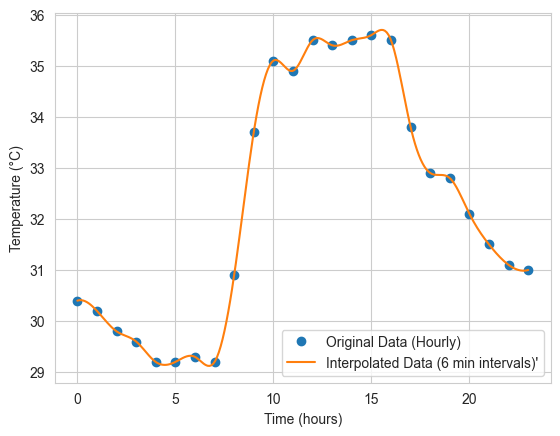

In [416]:
# Apply cubic spline interpolator to summer data

cs_sum = CubicSpline(df_sum_day["time"], df_sum_day["temp(c)"])

new_time = np.linspace(df_sum_day["time"].min(), df_sum_day["time"].max(), 24 * 10)  # 24 hours with 10 time steps each: 24 * 10

# Interpolate the temperature at these new time points
interpolated_temps = cs_sum(new_time)
# Round to 10dp
interpolated_temps = np.round(interpolated_temps, 10)

# Create a DataFrame for better visualization
df_interpolated_sum = pd.DataFrame({
    "time": new_time,
    "temp_s(c)": interpolated_temps
})


# Plot the original data and the interpolated data
plt.plot(df_sum_day["time"], df_sum_day["temp(c)"], "o", label="Original Data (Hourly)")
plt.plot(df_interpolated_sum["time"], df_interpolated_sum["temp_s(c)"], "-", label="Interpolated Data (6 min intervals)'")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

df_interpolated_sum.to_csv("processed-data/20230711_interpolated.csv", index=False)

# Average Hourly Air Temperatures for Winter and Summer - Modelling for boundary conditions

In [417]:
df_winter_avg = df_winter[["time", "temp(c)"]].copy()

df_winter_avg_hr = df_winter_avg.groupby("time")["temp(c)"].mean().reset_index()

cs_wnt_hr = CubicSpline(df_winter_avg_hr["time"], df_winter_avg_hr["temp(c)"])

new_time = np.linspace(df_winter_avg_hr["time"].min(), df_winter_avg_hr["time"].max(), 24 * 10)  # 24 hours with 10 time steps each: 24 * 10

# Interpolate the temperature at these new time points
interpolated_temps = cs_wnt_hr(new_time)
# Round to 10dp
interpolated_temps = np.round(interpolated_temps, 10)

# Create a DataFrame for better visualization
df_interpolated_wnt_hr = pd.DataFrame({
    "time": new_time,
    "temp(c)": interpolated_temps
})

df_interpolated_wnt_hr.to_csv("processed-data/2023_winter_avg_hr.csv", index=False)

# Summer

df_summer_avg = df_summer[["time", "temp(c)"]].copy()

df_summer_avg_hr = df_summer_avg.groupby("time")["temp(c)"].mean().reset_index()

cs_sum_hr = CubicSpline(df_summer_avg_hr["time"], df_summer_avg_hr["temp(c)"])

new_time = np.linspace(df_summer_avg_hr["time"].min(), df_summer_avg_hr["time"].max(), 24 * 10)  # 24 hours with 10 time steps each: 24 * 10

# Interpolate the temperature at these new time points
interpolated_temps = cs_sum_hr(new_time)
# Round to 10dp
interpolated_temps = np.round(interpolated_temps, 10)

# Create a DataFrame for better visualization
df_interpolated_sum_hr = pd.DataFrame({
    "time": new_time,
    "temp(c)": interpolated_temps
})

df_interpolated_sum_hr.to_csv("processed-data/2023_summer_avg_hr.csv", index=False)

# Post-Process modelled results

In [418]:
df_results = pd.read_csv("processed-data/2023_sum_win_results.csv")

df_results["energy_flow_w(Wh/m^2)"] = df_results["heat_flux_w(W/m^2)"] * 0.1 
df_results["cumulative_energy_w"] = df_results["energy_flow_w(Wh/m^2)"].cumsum()

df_results["energy_flow_s(Wh/m^2)"] = df_results["heat_flux_s(W/m^2)"] * 0.1  
df_results["cumulative_energy_s"] = df_results["energy_flow_s(Wh/m^2)"].cumsum()

df_results = df_results.merge(df_interpolated_wnt[["temp_w(c)"]], left_index=True, right_index=True)
df_results = df_results.merge(df_interpolated_sum[["temp_s(c)"]], left_index=True, right_index=True)

df_results

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 665: invalid start byte

In [ ]:
# Plot heat flux on primary y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(df_results["time"], df_results["heat_flux_w(W/m^2)"], label="Heat Flux", color="tab:red")
ax1.set_xlabel("Time (Hour of the Day)")
ax1.set_ylabel("Heat Flux (W/m²)", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create secondary y-axis for air temperature
ax2 = ax1.twinx()
ax2.plot(df_results["time"], df_results["temp_w(c)"], label="Air Temperature", color="tab:blue")
ax2.set_ylabel("Air Temperature (°C)", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Set title
plt.title("Heat Flux Leaving the System at Boundary A during a Winter Day (10/01)")

# Set x-axis ticks (convert time from seconds to hours)
tick_positions = [i * 3600 for i in range(0, 25, 2)] 
tick_labels = range(0, 25, 2) 
ax1.set_xticks(tick_positions) 
ax1.set_xticklabels(tick_labels)

# Set x-axis limits to match the data range (removes left/right gaps)
plt.xlim(df_results["time"].min(), df_results["time"].max())

# Synchronize y-ticks spacing

# Grid and layout adjustments
ax2.grid(True, linestyle="dotted", alpha=0.6)

plt.savefig("output-graphs/model/heat_flux_winter.png", dpi=1000)

plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

sns.lineplot(x="time", y="cumulative_energy_w", data=df_results)
plt.title("Cumulative Energy Flow from Boundary A during a Winter Day (10/01)")
plt.ylabel("Energy Flow (Wh/m^2)")
plt.xlabel("Time (Hour of the Day)")

tick_positions = [i * 3600 for i in range(0, 25, 2)]  # Convert hours to seconds
tick_labels = range(0, 25, 2)  # Labels remain in hours

plt.xticks(tick_positions, tick_labels)

# Set x-axis limits to match the data range (removes left/right gaps)
plt.xlim(df_results["time"].min(), df_results["time"].max())

plt.savefig("output-graphs/model/energy_flow_winter.png", dpi=1000)

plt.show()

In [ ]:
# Plot heat flux on primary y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(df_results["time"], df_results["heat_flux_s(W/m^2)"], label="Heat Flux", color="tab:red")
ax1.set_xlabel("Time (Hour of the Day)")
ax1.set_ylabel("Heat Flux (W/m²)", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create secondary y-axis for air temperature
ax2 = ax1.twinx()
ax2.plot(df_results["time"], df_results["temp_s(c)"], label="Air Temperature", color="tab:blue")
ax2.set_ylabel("Air Temperature (°C)", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Set title
plt.title("Heat Flux Leaving the System at Boundary A during a Summer Day (11/07)")

# Set x-axis ticks (convert time from seconds to hours)
tick_positions = [i * 3600 for i in range(0, 25, 2)] 
tick_labels = range(0, 25, 2) 
ax1.set_xticks(tick_positions) 
ax1.set_xticklabels(tick_labels)

# Set x-axis limits to match the data range (removes left/right gaps)
plt.xlim(df_results["time"].min(), df_results["time"].max())

# Synchronize y-ticks spacing

# Grid and layout adjustments
ax2.grid(True, linestyle="dotted", alpha=0.6)
fig.tight_layout()
plt.savefig("output-graphs/model/heat_flux_summer.png", dpi=1000)

plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

sns.lineplot(x="time", y="cumulative_energy_s", data=df_results)
plt.title("Cumulative Energy Flow from Boundary A during a Summer Day (11/07)")
plt.ylabel("Energy Flow (Wh/m^2)")
plt.xlabel("Time (Hour of the Day)")

tick_positions = [i * 3600 for i in range(0, 25, 2)]  # Convert hours to seconds
tick_labels = range(0, 25, 2)  # Labels remain in hours

plt.xticks(tick_positions, tick_labels)

# Set x-axis limits to match the data range (removes left/right gaps)
plt.xlim(df_results["time"].min(), df_results["time"].max())
plt.ylim(0,)

plt.savefig("output-graphs/model/energy_flow_summer.png", dpi=1000)

plt.show()